# Deep Learning Model: Convolutional Neural Network
## Business Problem
Leukemia is a type of cancer of the blood that often affects young people. In the past, pathologists would diagnose patients by eye after examining blood smear images under the microscope. But, this is time consuming and tedious. Advances in image recognition technology have come a long ways since their inception. Therefore, automated solutions using computers would be of great benefit to the medical community to aid in cancer diagnoses.

The goal of this project is to address the following question: How can the doctor’s at the Munich University Hospital automate the diagnosis of patients with leukemia using images from blood smears?

## Approach
I will use Keras to create a convolutional neural network to classify the 15 different types of leukocyte. At this stage, no preprocessing will be done to counter the class imbalance (boostrapping or image augmentation). However, during development of the second model, I will considering weighting the classes at the time of training to acount for the class imbalance.

In [1]:
import sys
sys.path.append('..')
from time import time

from keras import layers
from keras import metrics
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from src.data_setup import make_dataset as md
from src.modeling import evaluate_model as em

%matplotlib inline

## Load Data
Load the pickled training and test data.

In [2]:
X_train, X_test, y_train, y_test = md.load_train_test('gray_rescale12')

In [3]:
X_train.shape

(14692, 2304)

In [4]:
pd.Series(y_train).value_counts()

NGS    6787
LYT    3150
MYO    2615
MON    1431
EOS     339
NGB      87
BAS      63
EBO      62
PMO      56
MYB      34
MOB      21
PMB      14
KSC      12
MMZ      12
LYA       9
dtype: int64

In [5]:
pd.Series(y_test).value_counts()

NGS    1697
LYT     787
MYO     653
MON     358
EOS      85
NGB      22
EBO      16
BAS      16
PMO      14
MYB       8
MOB       5
PMB       4
MMZ       3
KSC       3
LYA       2
dtype: int64

## Data Preparation
### Unflatten
Unflatten the feature arrays, converting them back into arrays of 2-dimensional images.

In [6]:
def unflatten(X):
    dimension = int(np.sqrt(X.shape[1]))
    return X.reshape((len(X), dimension, dimension, 1))

In [7]:
X_train_unflatten = unflatten(X_train)
X_train_unflatten.shape

(14692, 48, 48, 1)

In [8]:
X_test_unflatten = unflatten(X_test)
X_test_unflatten.shape

(3673, 48, 48, 1)

### Normalize
Normalize the features, to values between 0 and 1.

In [9]:
print(f'The maximum value for the training set is {X_train_unflatten.max()}.')
print(f'The maximum value for the test set is {X_test_unflatten.max()}.')

The maximum value for the training set is 255.
The maximum value for the test set is 255.


In [10]:
X_train_normalized = X_train_unflatten / X_train_unflatten.max()
X_test_normalized = X_test_unflatten / X_test_unflatten.max()

In [11]:
print(f'The maximum value for the normalized training set is {X_train_normalized.max()}.')
print(f'The maximum value for the normalized test set is {X_test_normalized.max()}.')

The maximum value for the normalized training set is 1.0.
The maximum value for the normalized test set is 1.0.


### Categories
First, encode the labels to integer values.

In [12]:
label_encodings = {value: i for i, value in enumerate(np.unique(y_train))}

In [13]:
label_encodings

{'BAS': 0,
 'EBO': 1,
 'EOS': 2,
 'KSC': 3,
 'LYA': 4,
 'LYT': 5,
 'MMZ': 6,
 'MOB': 7,
 'MON': 8,
 'MYB': 9,
 'MYO': 10,
 'NGB': 11,
 'NGS': 12,
 'PMB': 13,
 'PMO': 14}

In [14]:
pd.Series(y_train).value_counts()

NGS    6787
LYT    3150
MYO    2615
MON    1431
EOS     339
NGB      87
BAS      63
EBO      62
PMO      56
MYB      34
MOB      21
PMB      14
KSC      12
MMZ      12
LYA       9
dtype: int64

In [15]:
y_train_encoded = pd.Series(y_train).replace(label_encodings).values
y_test_encoded = pd.Series(y_test).replace(label_encodings).values

In [16]:
np.unique(y_train_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [17]:
np.unique(y_test_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Second, encode the integer labels as one-hot vectors.

In [18]:
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [19]:
y_train_one_hot.shape

(14692, 15)

In [20]:
y_train_one_hot[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

In [21]:
y_test_one_hot.shape

(3673, 15)

In [22]:
y_test_one_hot[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

## Validation Set
Now that we have preprocessed the training data, I will create a validation set. This will be used to evaluate how the deep learning model is training.

In [23]:
X_train_normalized, X_val, y_train_one_hot, y_val = train_test_split(X_train_normalized, y_train_one_hot, test_size=0.1, random_state=42)

## Define Model

In [24]:
input_shape = X_train_unflatten.shape[1:]
print(f'The input shape is {input_shape}.')

The input shape is (48, 48, 1).


In [25]:
model_1a = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(16, kernel_size=(7, 7), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(38, activation='relu'),
    layers.Dense(15, activation='softmax')
])

In [26]:
model_1a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense (Dense)                (None, 600)               778200    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               9

### Train Model

In [27]:
model_1a.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[
                  metrics.Accuracy(),
                  metrics.categorical_accuracy,
                  metrics.Precision(),
                  metrics.Recall()
              ])
results_1 = model_1a.fit(X_train_normalized, y_train_one_hot, validation_data=(X_val, y_val), epochs=50, batch_size=64)

Epoch 1/50
207/207 [==============================] - 9s 40ms/step - loss: 1.2076 - accuracy: 0.0000e+00 - categorical_accuracy: 0.6099 - precision: 0.7487 - recall: 0.4480 - val_loss: 0.6274 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.8163 - val_precision: 0.8701 - val_recall: 0.7748
Epoch 2/50
207/207 [==============================] - 8s 37ms/step - loss: 0.5879 - accuracy: 0.0000e+00 - categorical_accuracy: 0.8187 - precision: 0.8707 - recall: 0.7681 - val_loss: 0.5020 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.8544 - val_precision: 0.8835 - val_recall: 0.8252
Epoch 3/50
207/207 [==============================] - 7s 36ms/step - loss: 0.4723 - accuracy: 0.0000e+00 - categorical_accuracy: 0.8534 - precision: 0.8890 - recall: 0.8231 - val_loss: 0.4882 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.8429 - val_precision: 0.8993 - val_recall: 0.8020
Epoch 4/50
207/207 [==============================] - 7s 35ms/step - loss: 0.4162 - accuracy: 0.0000e+0

#### Predictions
Make class predictions using the model.

In [28]:
y_pred_cnn = model_1a.predict(X_test_normalized)

### Evaluate the Model

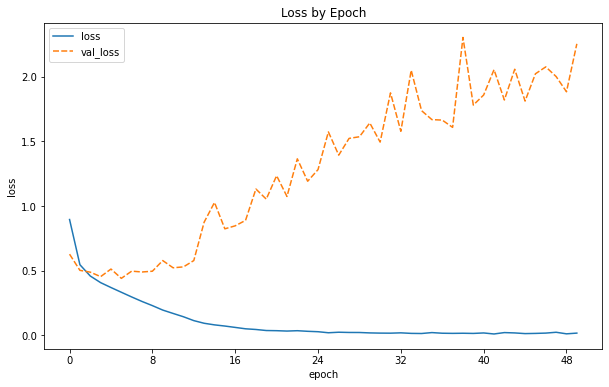

In [29]:
em.plot_train_val_losses(results_1, figure_name='losses_model_1a')

In [31]:
print(classification_report(np.argmax(y_test_one_hot, axis=1), np.argmax(y_pred_cnn, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.50      0.50      0.50        16
           2       0.68      0.31      0.42        85
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.85      0.93      0.89       787
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         5
           8       0.61      0.72      0.66       358
           9       0.00      0.00      0.00         8
          10       0.83      0.82      0.83       653
          11       0.00      0.00      0.00        22
          12       0.97      0.95      0.96      1697
          13       0.00      0.00      0.00         4
          14       0.50      0.21      0.30        14

    accuracy                           0.86      3673
   macro avg       0.33      0.30      0.30      3673
weighted avg       0.86   

/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

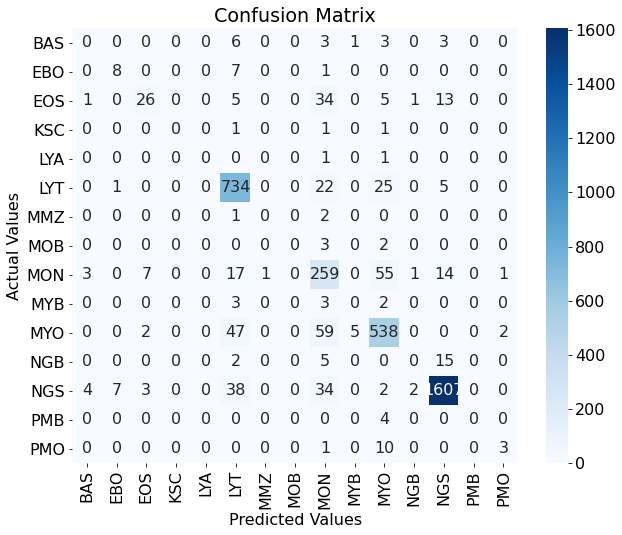

In [32]:
em.plot_confusion_matrix(y_test_one_hot, y_pred_cnn, label_encodings, figure_name='cm_model_1a')

### Train Model - Use Weighted Classes
To counter the class imbalance, I will try weighting the classes by importance. More weight will be given to the classes with less representation.

In [33]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

In [34]:
class_weights_dict

{0: 15.547089947089948,
 1: 15.79784946236559,
 2: 2.889282202556539,
 3: 81.62222222222222,
 4: 108.82962962962964,
 5: 0.31094179894179896,
 6: 81.62222222222222,
 7: 46.64126984126984,
 8: 0.6844630794316329,
 9: 28.807843137254903,
 10: 0.3745570427023582,
 11: 11.25823754789272,
 12: 0.14431511222435048,
 13: 69.96190476190476,
 14: 17.49047619047619}

In [35]:
model_1b = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(16, kernel_size=(7, 7), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(38, activation='relu'),
    layers.Dense(15, activation='softmax')
])

In [36]:
model_1b.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=[
                    metrics.Accuracy(),
                    metrics.categorical_accuracy,
                    metrics.Precision(),
                    metrics.Recall()
                ])
results_2 = model_1b.fit(X_train_normalized, y_train_one_hot, validation_data=(X_val, y_val), epochs=50, batch_size=64, class_weight=class_weights_dict)

Epoch 1/50
207/207 [==============================] - 8s 38ms/step - loss: 2.8068 - accuracy: 0.0000e+00 - categorical_accuracy: 0.1328 - precision_1: 0.0114 - recall_1: 4.7076e-05 - val_loss: 2.4710 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.5612 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
207/207 [==============================] - 8s 37ms/step - loss: 2.6788 - accuracy: 0.0000e+00 - categorical_accuracy: 0.3527 - precision_1: 0.8076 - recall_1: 0.0237 - val_loss: 1.7382 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.5197 - val_precision_1: 0.9579 - val_recall_1: 0.1857
Epoch 3/50
207/207 [==============================] - 8s 37ms/step - loss: 2.4320 - accuracy: 0.0000e+00 - categorical_accuracy: 0.5365 - precision_1: 0.8892 - recall_1: 0.2320 - val_loss: 1.4987 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.5449 - val_precision_1: 0.9426 - val_recall_1: 0.2680
Epoch 4/50
207/207 [==============================] - 8s 37ms/step 

In [37]:
results_2.history.keys()

dict_keys(['loss', 'accuracy', 'categorical_accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_categorical_accuracy', 'val_precision_1', 'val_recall_1'])

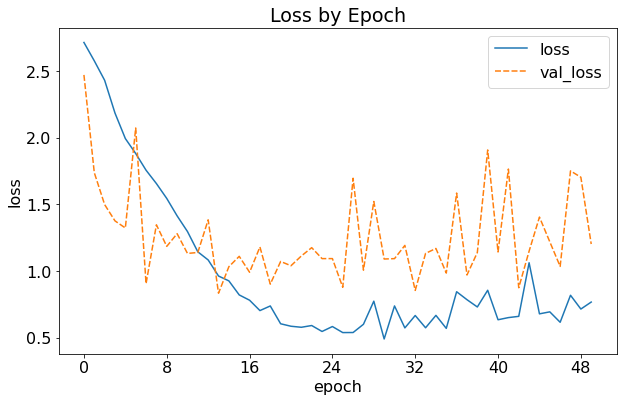

In [38]:
em.plot_train_val_losses(results_2, figure_name='losses_model_1b')

**Observations:** The chaotic loss indicates that the model is unable to learn anything useful from the training data.

### Predictions

In [39]:
y_pred_cnn_2 = model_1b.predict(X_test_normalized)

In [40]:
print(classification_report(np.argmax(y_test_one_hot, axis=1), np.argmax(y_pred_cnn_2, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.16      0.44      0.23        16
           2       0.21      0.62      0.31        85
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.88      0.78      0.83       787
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         5
           8       0.49      0.59      0.53       358
           9       0.00      0.00      0.00         8
          10       0.83      0.57      0.67       653
          11       0.02      0.36      0.05        22
          12       0.98      0.70      0.82      1697
          13       0.00      0.00      0.00         4
          14       0.08      0.50      0.14        14

    accuracy                           0.67      3673
   macro avg       0.24      0.30      0.24      3673
weighted avg       0.84   

/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

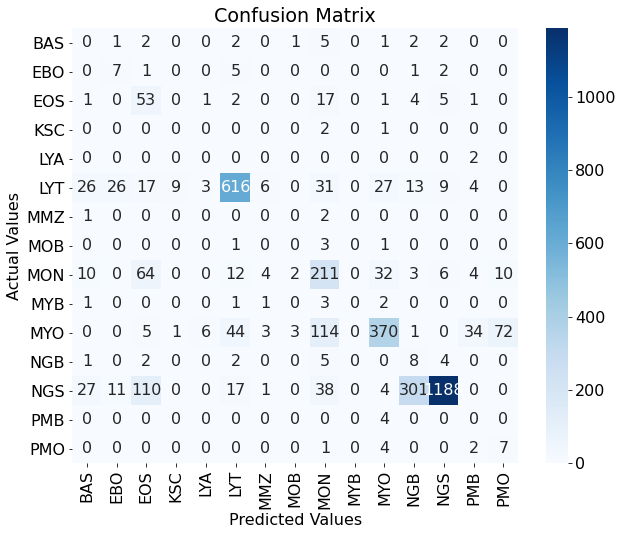

In [41]:
em.plot_confusion_matrix(y_test_one_hot, y_pred_cnn_2, label_encodings, figure_name='cm_model_1b')

## Summary
I created a deepling model using a convolutional neural network (CNN) to predict the 15 different classes of leukocite. The model used weighted classes to counter class imbalance. The dataset of images was rescaled by 12% and converted to grayscale.

After examining the training performance by comparing the validation and training loss over epoch, I determined that the model is having difficulty learning anything useful from the data. There are several factors that could contribute to this poor model performance. A few factors include:

1. Class imbalance issues.
2. Insufficient features due to rescaled images.
3. Wrong model architecture.

## Future Direction

I will begin addressing these factors by starting with factor 1. My approach will be to select a subset of the data that includes leukocite morphologies with roughly equal class counts. Then, I will test my model on this subset and evaluate the performance.